In [1]:
from sympy import *
import numpy as np
from scipy.linalg import norm
from itertools import combinations
import pandas as pd

from direct_lingam.ReLVLiNGAM import *
from direct_lingam.simulate_data import *
from direct_lingam.DAG import plot_dag
import pyximport; pyximport.install(inplace=True)

from models import IVModel

Lambda is 
 [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 1 0]]


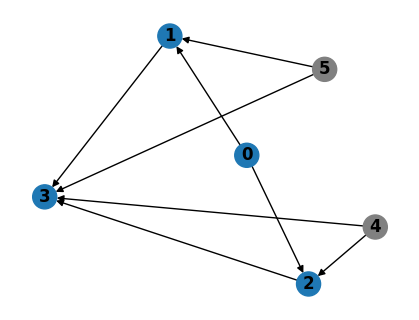

In [2]:
Lambda = get_Lambda([(1,0), (2,0), (3, 1), (3, 2)], 4)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
highest_l = 1
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [3]:
import multiprocess as mp


reps = 20

def run_experiment(seed):
    # run the experiment using the given parameters
        # Set the random seed
    noise_distribution = 'beta'
    samples_sizes = [10**n for n in range(1, 8)]
    n_max = int(max(samples_sizes))
    # p, q = Lambda.shape[0], Lambda.shape[1]+Gamma.shape[1]

    np.random.seed(seed)
    X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
    causal_effect_true = [true_B[3, 1], true_B[3, 2]]

    # Perform the experiment
    causal_effect_estimates_cumulant_1, causal_effect_estimates_cumulant_2 =  [], []
    causal_effect_estimates_cumulant_projected_1, causal_effect_estimates_cumulant_projected_2 = [], []
    dist_to_line = []
    causal_effect_estimate_min_norm_1, causal_effect_estimate_min_norm_2 = [], []

    for n in samples_sizes:
        X_sample = X[:int(n), :]
        X_sample = np.asfortranarray(X_sample)
        X_sample = X_sample - np.median(X_sample, axis=0)

        iv_model = IVModel(X_sample, highest_l = 1)
        causal_effect_estimate_cumulant_projected, causal_effect_estimate_cumulant, causal_effect_estimate_min_norm = iv_model.estimate_effect()

        causal_effect_estimates_cumulant_1.append(causal_effect_estimate_cumulant[0])
        causal_effect_estimates_cumulant_2.append(causal_effect_estimate_cumulant[1])

        causal_effect_estimates_cumulant_projected_1.append(causal_effect_estimate_cumulant_projected[0])
        causal_effect_estimates_cumulant_projected_2.append(causal_effect_estimate_cumulant_projected[1])

        causal_effect_estimate_min_norm_1.append(causal_effect_estimate_min_norm[0])
        causal_effect_estimate_min_norm_2.append(causal_effect_estimate_min_norm[1])

        a = iv_model.regs[1:-1]
        c = iv_model.regs[-1]
        dist_to_line.append((np.dot(causal_effect_true, a) - c)/np.dot(a, a))
    # Create a DataFrame for the current seed
    seed_df = pd.DataFrame({
        'Seed': [seed] * len(samples_sizes),
        'Sample Size': samples_sizes,
        'True Effect 1': [causal_effect_true[0]] * len(samples_sizes),
        'True Effect 2': [causal_effect_true[1]] * len(samples_sizes),
        'Causal Effect Estimate 1 (Cumulant)': causal_effect_estimates_cumulant_1,
        'Causal Effect Estimate 2 (Cumulant)': causal_effect_estimates_cumulant_2,
        'Causal Effect Estimate 1 (Cumulant Projected)': causal_effect_estimates_cumulant_projected_1,
        'Causal Effect Estimate 2 (Cumulant Projected)': causal_effect_estimates_cumulant_projected_2,
        'Causal Effect Estimate 1 (Min Norm)': causal_effect_estimate_min_norm_1,
        'Causal Effect Estimate 2 (Min Norm)': causal_effect_estimate_min_norm_2,
        'Distance to Line': dist_to_line
    })
    return seed_df




def parallel_simulation(reps):
    pool = mp.Pool(mp.cpu_count())

    seeds = range(reps)
    results = pool.map(run_experiment, seeds)

    pool.close()
    return pd.concat(results, ignore_index=True)

results_df = parallel_simulation(reps)

Using 12 processes


/Users/daniele/Library/CloudStorage/OneDrive-TUM/Math/generilized_did/generilized_did/models.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)


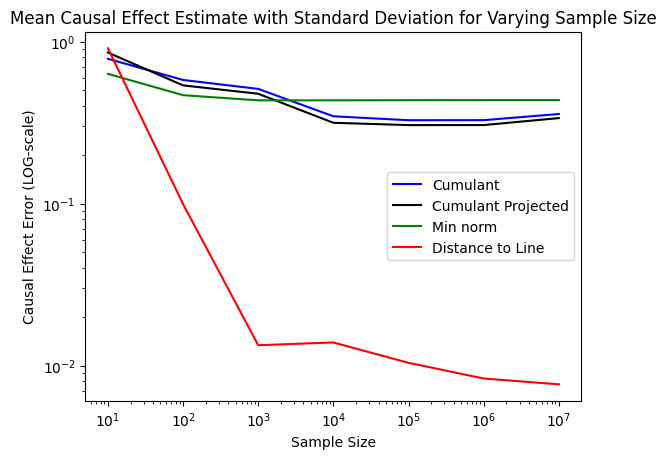

In [4]:
import matplotlib.pyplot as plt

results_df["Cumulant Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Cumulant)'] - results_df["True Effect 1"]))
# /results_df["True Effect 1"])  # Calculate the error
results_df["Cumulant Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Cumulant)'] - results_df["True Effect 2"]))
# /results_df["True Effect 2"])  # Calculate the error
results_df["Cumulant Error"] = np.median([results_df["Cumulant Error 1"], results_df["Cumulant Error 2"]], axis=0)
results_df["Min Norm Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Min Norm)'] - results_df["True Effect 1"]))
# /results_df["True Effect 1"])  # Calculate the error
results_df["Min Norm Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Min Norm)'] - results_df["True Effect 2"]))
# /results_df["True Effect 2"])  # Calculate the error
results_df["Min Norm Error"] = np.median([results_df["Min Norm Error 1"], results_df["Min Norm Error 2"]], axis=0)
results_df["Cumulant Projected Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Cumulant Projected)'] - results_df["True Effect 1"]))
# /results_df["True Effect 1"])  # Calculate the error
results_df["Cumulant Projected Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Cumulant Projected)'] - results_df["True Effect 2"]))
# /results_df["True Effect 2"])  # Calculate the error
results_df["Cumulant Projected Error"] = np.median([results_df["Cumulant Projected Error 1"], results_df["Cumulant Projected Error 2"]], axis=0)


# results_df["Ratio Test Error"] = np.abs((results_df['Causal Effect Estimate (Ratio Test)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
# results_df["Cumulant Error With True Matrix"] = np.abs((results_df['Causal Effect Estimate (Cumulant With True Matrix)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
# results_df["Ratio Test After Matching Error"] = np.abs((results_df['Causal Effect Estimate (Ratio Test After Matching)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
# results_df["CM Error"] = np.abs((results_df['Cross Moment'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error

# # Group the results by sample size and calculate the mean
mean_results = results_df.groupby('Sample Size').mean()
mean_sd = results_df.groupby('Sample Size').std()

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(mean_results.index, mean_results["Cumulant Error"],
         label='Cumulant',
         color = "blue")

plt.plot(mean_results.index, mean_results["Cumulant Projected Error"],
         label='Cumulant Projected',
         color = "black")
plt.plot(mean_results.index, np.abs(mean_results["Min Norm Error"]),
         label='Min norm',
         color = "green")
plt.plot(mean_results.index, np.abs(mean_results["Distance to Line"]),
         label='Distance to Line',
         color = "red")

plt.xlabel('Sample Size')
plt.ylabel('Causal Effect Error (LOG-scale)')
plt.legend()
plt.title('Mean Causal Effect Estimate with Standard Deviation for Varying Sample Size')
plt.show()

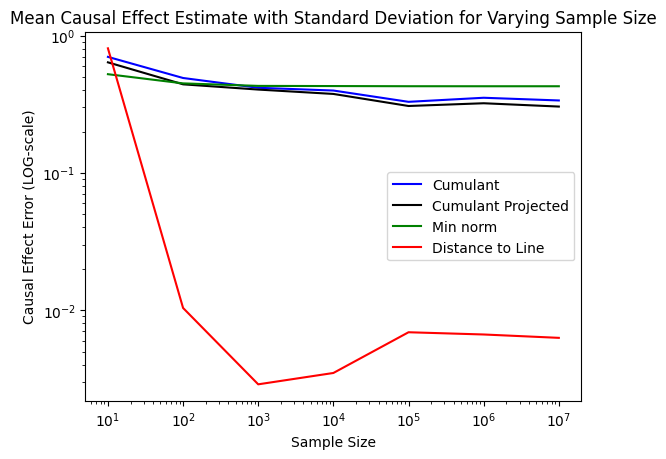

In [12]:
import matplotlib.pyplot as plt

results_df["Cumulant Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Cumulant)'] - results_df["True Effect 1"]))
# /results_df["True Effect 1"])  # Calculate the error
results_df["Cumulant Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Cumulant)'] - results_df["True Effect 2"]))
# /results_df["True Effect 2"])  # Calculate the error
results_df["Cumulant Error"] = np.median([results_df["Cumulant Error 1"], results_df["Cumulant Error 2"]], axis=0)
results_df["Min Norm Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Min Norm)'] - results_df["True Effect 1"]))
# /results_df["True Effect 1"])  # Calculate the error
results_df["Min Norm Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Min Norm)'] - results_df["True Effect 2"]))
# /results_df["True Effect 2"])  # Calculate the error
results_df["Min Norm Error"] = np.median([results_df["Min Norm Error 1"], results_df["Min Norm Error 2"]], axis=0)
results_df["Cumulant Projected Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Cumulant Projected)'] - results_df["True Effect 1"]))
# /results_df["True Effect 1"])  # Calculate the error
results_df["Cumulant Projected Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Cumulant Projected)'] - results_df["True Effect 2"]))
# /results_df["True Effect 2"])  # Calculate the error
results_df["Cumulant Projected Error"] = np.median([results_df["Cumulant Projected Error 1"], results_df["Cumulant Projected Error 2"]], axis=0)


# results_df["Ratio Test Error"] = np.abs((results_df['Causal Effect Estimate (Ratio Test)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
# results_df["Ratio Test After Matching Error"] = np.abs((results_df['Causal Effect Estimate (Ratio Test After Matching)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
# results_df["Cumulant Error With True Matrix"] = np.abs((results_df['Causal Effect Estimate (Cumulant With True Matrix)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
# results_df["CM Error"] = np.abs((results_df['Cross Moment'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error

# # Group the results by sample size and calculate the mean
mean_results = results_df.groupby('Sample Size').mean()
mean_sd = results_df.groupby('Sample Size').std()

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(mean_results.index, mean_results["Cumulant Error"],
         label='Cumulant',
         color = "blue")

plt.plot(mean_results.index, mean_results["Cumulant Projected Error"],
         label='Cumulant Projected',
         color = "black")
plt.plot(mean_results.index, np.abs(mean_results["Min Norm Error"]),
         label='Min norm',
         color = "green")
plt.plot(mean_results.index, np.abs(mean_results["Distance to Line"]),
         label='Distance to Line',
         color = "red")

# plt.plot(mean_results.index, mean_results["Cumulant Error 1"],
#          label='Cumulant 1',
#          color = "blue")

# plt.plot(mean_results.index, mean_results["Cumulant Error 2"],
#          label='Cumulant 2',
#          color = "black")

# plt.plot(mean_results.index, mean_results["Cumulant Projected Error 1"],
#          label='Cumulant projected 1',
#          color = "red")

# plt.plot(mean_results.index, mean_results["Cumulant Projected Error 2"],
#          label='Cumulant projected 2',
#          color = "green")

# plt.plot(mean_results.index, mean_results["Ratio Test Error"],
#          label='Ratio Test',
#          color = "red")

# plt.plot(mean_results.index, mean_results["Ratio Test After Matching Error"],
#          label='Ratio Test After Matching Error',
#          color = "green")

# plt.fill_between(mean_results.index,
#                  mean_results['Cumulant Error'] + mean_sd['Cumulant Error'],
#                  mean_results['Cumulant Error'] - mean_sd['Cumulant Error'],
#                  color = "blue",
#                  alpha=0.2)


# plt.fill_between(mean_results.index,
#                  mean_results['Ratio Test Error'] + mean_sd['Ratio Test Error'],
#                  mean_results['Ratio Test Error'] - mean_sd['Ratio Test Error'],
#                  alpha=0.2,
#                  color = "red")


# plt.fill_between(mean_results.index,
#                  mean_results['Latent Factor Error'] + mean_sd['Latent Factor Error'],
#                  mean_results['Latent Factor Error'] - mean_sd['Latent Factor Error'],
#                  alpha=0.2,
#                  color = "green")


# plt.fill_between(mean_results.index,
#                  mean_results['CM Error'] + mean_sd['CM Error'],
#                  mean_results['CM Error'] - mean_sd['CM Error'],
#                  alpha=0.2,
#                  color = "black")



plt.xlabel('Sample Size')
plt.ylabel('Causal Effect Error (LOG-scale)')
plt.legend()
plt.title('Mean Causal Effect Estimate with Standard Deviation for Varying Sample Size')
plt.show()